<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch04_training_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 04 — Training Models

## 1) Summary
This chapter focuses on how models are trained and optimized:
- Linear Regression: Normal Equation (closed-form) and Gradient Descent
- Gradient Descent variants: Batch, Stochastic, and Mini-batch
- Polynomial Regression + Learning Curves (bias–variance, under/overfitting)
- Regularization: Ridge (L2), Lasso (L1), Elastic Net
- Early Stopping as a regularization technique
- Logistic Regression (binary) and Softmax Regression (multiclass)

## 2) Learning Goals
- Understand objective functions (MSE / log loss) and gradients.
- Compare Batch GD vs SGD vs Mini-batch GD and their trade-offs.
- Diagnose underfitting/overfitting using learning curves.
- Understand regularization effects on coefficients.
- Understand logistic/softmax regression and probabilistic outputs.


In [23]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


## 3) Synthetic Linear Data
We create a simple linear dataset with noise:
y = 4 + 3x + noise
This will be used to demonstrate training methods.


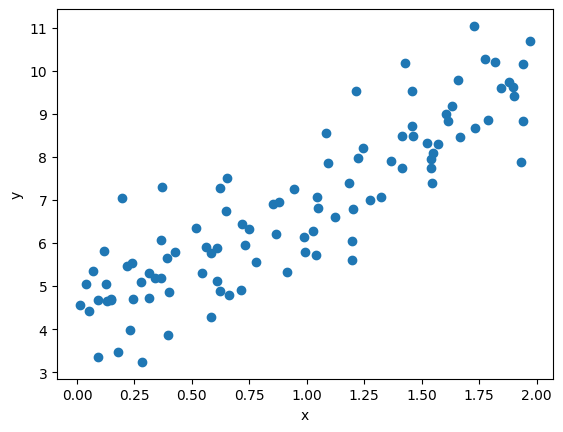

In [24]:
m = 100
X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.randn(m, 1)

plt.scatter(X, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## 4) Normal Equation (Closed-form Solution)
For Linear Regression, the optimal parameters can be computed directly:
theta = (X^T X)^(-1) X^T y
This is a closed-form solution (no iterations required).


In [25]:
X_b = np.c_[np.ones((m, 1)), X]  # add bias term
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best


array([[4.21509616],
       [2.77011339]])

## 5) Predictions with the Closed-form Solution
We use the learned parameters to predict values at x=0 and x=2 and plot the regression line.


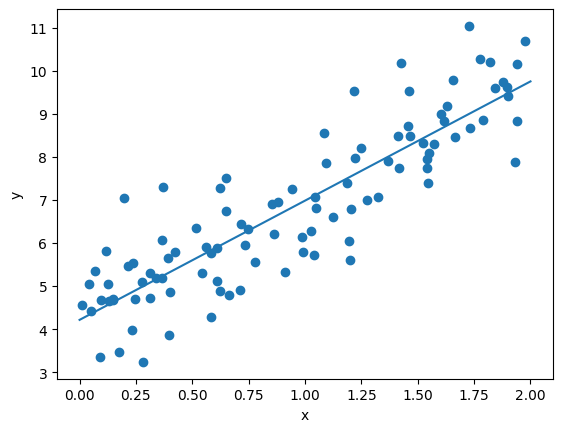

In [26]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b @ theta_best

plt.scatter(X, y)
plt.plot(X_new, y_predict)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## 6) scikit-learn LinearRegression
We confirm the result using scikit-learn’s implementation.


In [27]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_


(array([4.21509616]), array([[2.77011339]]))

## 7) Batch Gradient Descent (BGD)
We minimize the MSE cost function:
J(theta) = (1/m) * sum (theta^T x_i - y_i)^2

BGD uses the full dataset to compute the gradient at each step:
theta := theta - eta * grad(J)


In [28]:
eta = 0.1
n_iterations = 1000
m = len(X_b)

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = (2/m) * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

theta


array([[4.21509616],
       [2.77011339]])

## 8) Stochastic Gradient Descent (SGD) — manual
SGD updates parameters using one instance at a time.
It is noisier but often faster on large datasets.
A learning-rate schedule is commonly used.


In [29]:
n_epochs = 50
t0, t1 = 5, 50  # learning rate schedule parameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)
t = 0

for epoch in range(n_epochs):
    for i in np.random.permutation(m):
        xi = X_b[i:i+1]
        yi = y[i:i+1]
        gradients = 2 * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        t += 1

theta


array([[4.21378815],
       [2.76962859]])

## 9) SGDRegressor (scikit-learn)
We use the built-in SGDRegressor as a practical implementation.


In [30]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_


(array([4.24365286]), array([2.8250878]))

## 10) Polynomial Regression Data
We create a non-linear dataset and fit a polynomial model to capture curvature.


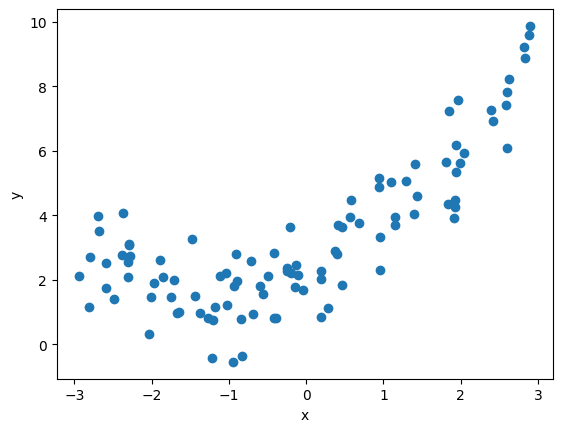

In [31]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.scatter(X, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## 11) Pipeline: PolynomialFeatures + LinearRegression
We transform input features into polynomial features and then apply linear regression.


In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

poly_reg = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("lin_reg", LinearRegression())
])

poly_reg.fit(X, y)


Pipeline(steps=[('poly_features', PolynomialFeatures(include_bias=False)),
                ('lin_reg', LinearRegression())])

## 12) Plot Polynomial Predictions
We visualize the fitted polynomial curve.


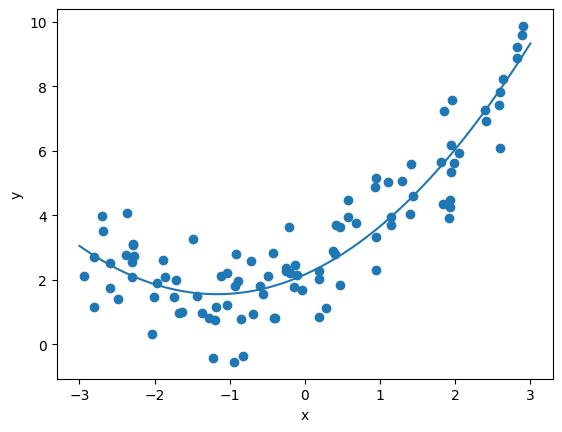

In [33]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
y_new = poly_reg.predict(X_new)

plt.scatter(X, y)
plt.plot(X_new, y_new)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## 13) Learning Curves (Bias–Variance Diagnosis)
Learning curves show how train/validation error evolves with more training data.
This helps diagnose underfitting vs overfitting.


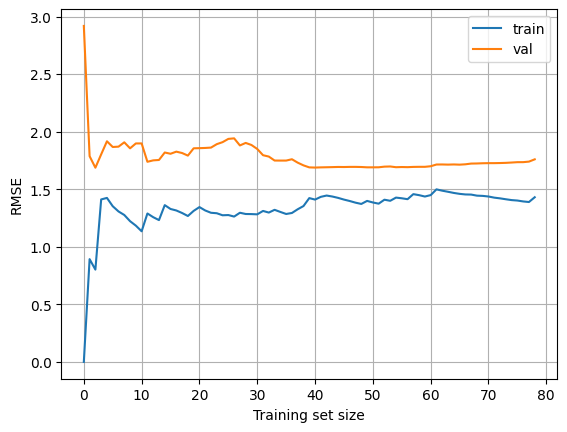

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_errors, val_errors = [], []
    for m in range(2, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error(y_val, y_val_pred))
    plt.plot(np.sqrt(train_errors), label="train")
    plt.plot(np.sqrt(val_errors), label="val")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)


## 14) Learning Curves for a High-degree Polynomial (Overfitting Example)
A high-degree polynomial can fit noise and overfit.
Learning curves typically show low train error but high validation error.


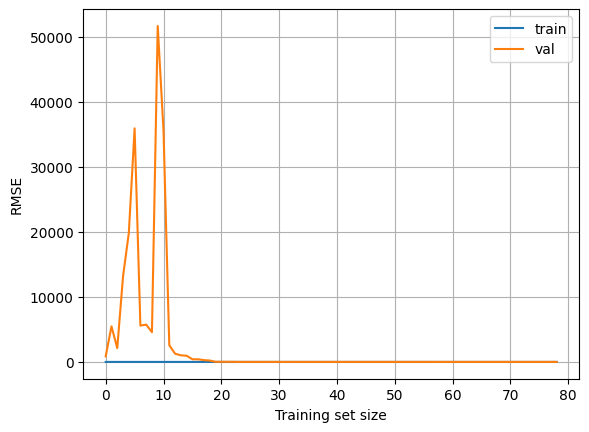

In [35]:
high_degree_poly = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(high_degree_poly, X, y)


## 15) Ridge Regression (L2 Regularization)
Ridge adds an L2 penalty:
MSE + alpha * sum(theta_j^2)

Higher alpha => smaller coefficients => less overfitting risk.


In [36]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1.0, random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])


array([4.9636362])

## 16) Lasso Regression (L1 Regularization)
Lasso adds an L1 penalty and often drives some coefficients to zero (sparsity).


In [37]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])


array([4.91113027])

## 17) Elastic Net (L1 + L2)
Elastic Net combines L1 and L2 penalties.
Useful when features are correlated and you want a balance between sparsity and stability.


In [38]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])


array([4.91101904])

## 18) Early Stopping (Regularization)
We train an SGD model iteratively and stop when validation error stops improving.
This acts as a form of regularization (prevents over-training).


In [39]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np

# High-degree polynomial features + scaling
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train, X_val, y_train, y_val = train_test_split(
    X, y.ravel(), test_size=0.2, random_state=42
)

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(
    max_iter=1,
    tol=None,                 # must be None or >= 0.0
    penalty=None,
    eta0=0.0005,
    learning_rate="constant",
    random_state=42,
    warm_start=True
)

minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(500):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

best_epoch, np.sqrt(minimum_val_error)


(27, np.float64(2.011941944402749))

**Early stopping result:** best epoch and best validation RMSE indicate when validation error stops improving (regularization effect).


## 19) Logistic Regression (Binary)
Logistic regression models the probability of the positive class:
p = sigmoid(theta^T x) = 1 / (1 + exp(-theta^T x))

It is commonly trained using log loss (cross-entropy).


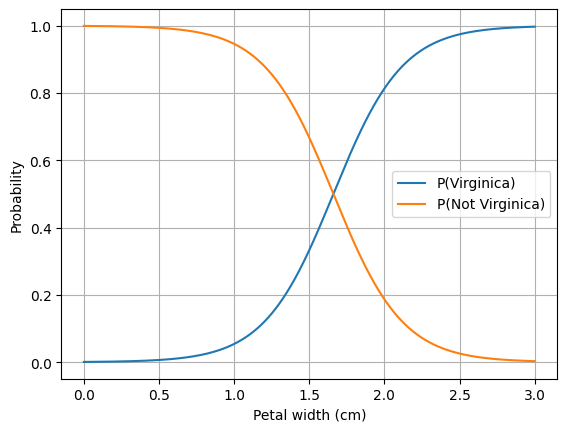

In [40]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

iris = datasets.load_iris()
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(int)  # Virginica?

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], label="P(Virginica)")
plt.plot(X_new, y_proba[:, 0], label="P(Not Virginica)")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()


## 20) Softmax Regression (Multiclass)
Softmax regression outputs a probability distribution over all classes.
The predicted class is the one with the highest probability.


In [41]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    C=10,
    random_state=42,
    max_iter=200
)
softmax_reg.fit(X, y)

softmax_reg.predict([[5, 2]]), softmax_reg.predict_proba([[5, 2]])


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


(array([2]), array([[6.21626374e-07, 5.73689802e-02, 9.42630398e-01]]))

## 21) Takeaways
- Linear Regression can be solved directly (Normal Equation) or iteratively (Gradient Descent).
- Batch GD is stable but expensive; SGD is fast but noisy; mini-batch balances both.
- Polynomial regression can overfit; learning curves help diagnose bias–variance.
- Ridge (L2) shrinks coefficients; Lasso (L1) can zero out coefficients; Elastic Net combines both.
- Early stopping is a practical and effective regularization method.
- Logistic regression provides probabilities for binary classification; softmax regression extends this to multiclass.

## 22) References
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 4.
- scikit-learn documentation: linear models, SGDRegressor, Ridge/Lasso/ElasticNet, LogisticRegression.
